In [46]:
# load the dependencies 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import  metrics
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler,OneHotEncoder
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [41]:
# load practice data from (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
df=pd.read_csv("Final_clean_house_data.csv")
df.head()






,BATHRM,HF_BATHRM,AC,ROOMS,BEDRM,SALEDATE,KITCHENS,FIREPLACES,LANDAREA,LONGITUDE,LATITUDE,QUADRANT,PRICE,ZIPCODE,WARD
0,3,1,Y,9,5,2016.0,2.0,4,1680,-77.040678,38.914684,NW,2100000.0,20009.0,2
1,3,1,Y,8,5,2006.0,2.0,3,1680,-77.040629,38.914683,NW,1602000.0,20009.0,2
2,3,2,Y,10,5,2010.0,1.0,4,2196,-77.039715,38.914331,NW,1950000.0,20009.0,2
3,3,1,Y,8,4,2011.0,2.0,1,1627,-77.040129,38.915408,NW,1050000.0,20009.0,2
4,3,1,Y,7,3,2018.0,2.0,1,1424,-77.039903,38.915017,NW,1430000.0,20009.0,2


In [3]:
# Separate the Features (X) from the Target (y)¶
y = df["PRICE"]
X = df.drop(columns="PRICE")

In [4]:
# Check the smaple size and number features
X.shape

(55028, 14)

In [5]:
# Check sample size of target
y.shape

(55028,)

# A. Data Preprocessing

In [6]:
# Check the data type of the features and also check missing values
X.dtypes

BATHRM          int64
HF_BATHRM       int64
AC             object
ROOMS           int64
BEDRM           int64
SALEDATE      float64
KITCHENS      float64
FIREPLACES      int64
LANDAREA        int64
LONGITUDE     float64
LATITUDE      float64
QUADRANT       object
ZIPCODE       float64
WARD            int64
dtype: object

In [7]:
# Generate our categorical variable list
df_cat = df.dtypes[df.dtypes == "object"].index.tolist()
df_cat

['AC', 'QUADRANT']

In [8]:
# Check the number of unique values in each column
df[df_cat].nunique()

AC          3
QUADRANT    4
dtype: int64

 There are no three features with unique values more than 10 and no need for binning

In [9]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[df_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(df_cat)
encode_df.head()

C:\Users\seidy\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,AC_0,AC_N,AC_Y,QUADRANT_NE,QUADRANT_NW,QUADRANT_SE,QUADRANT_SW
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [10]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(df_cat,1)
df.head()

C:\Users\seidy\AppData\Local\Temp\ipykernel_16400\634944062.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(df_cat,1)


,BATHRM,HF_BATHRM,ROOMS,BEDRM,SALEDATE,KITCHENS,FIREPLACES,LANDAREA,LONGITUDE,LATITUDE,PRICE,ZIPCODE,WARD,AC_0,AC_N,AC_Y,QUADRANT_NE,QUADRANT_NW,QUADRANT_SE,QUADRANT_SW
0,3,1,9,5,2016.0,2.0,4,1680,-77.040678,38.914684,2100000.0,20009.0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,3,1,8,5,2006.0,2.0,3,1680,-77.040629,38.914683,1602000.0,20009.0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3,2,10,5,2010.0,1.0,4,2196,-77.039715,38.914331,1950000.0,20009.0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3,1,8,4,2011.0,2.0,1,1627,-77.040129,38.915408,1050000.0,20009.0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3,1,7,3,2018.0,2.0,1,1424,-77.039903,38.915017,1430000.0,20009.0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [11]:
# Update feature data set
X = df.drop(columns="PRICE")
X.shape

(55028, 19)

Two many features and need to be reduced. There are many ways to reduce features.
- Researcher pre-determine most important features
- Use correlation matrix
- Select important features from model(e.g fiting RandomForest model )

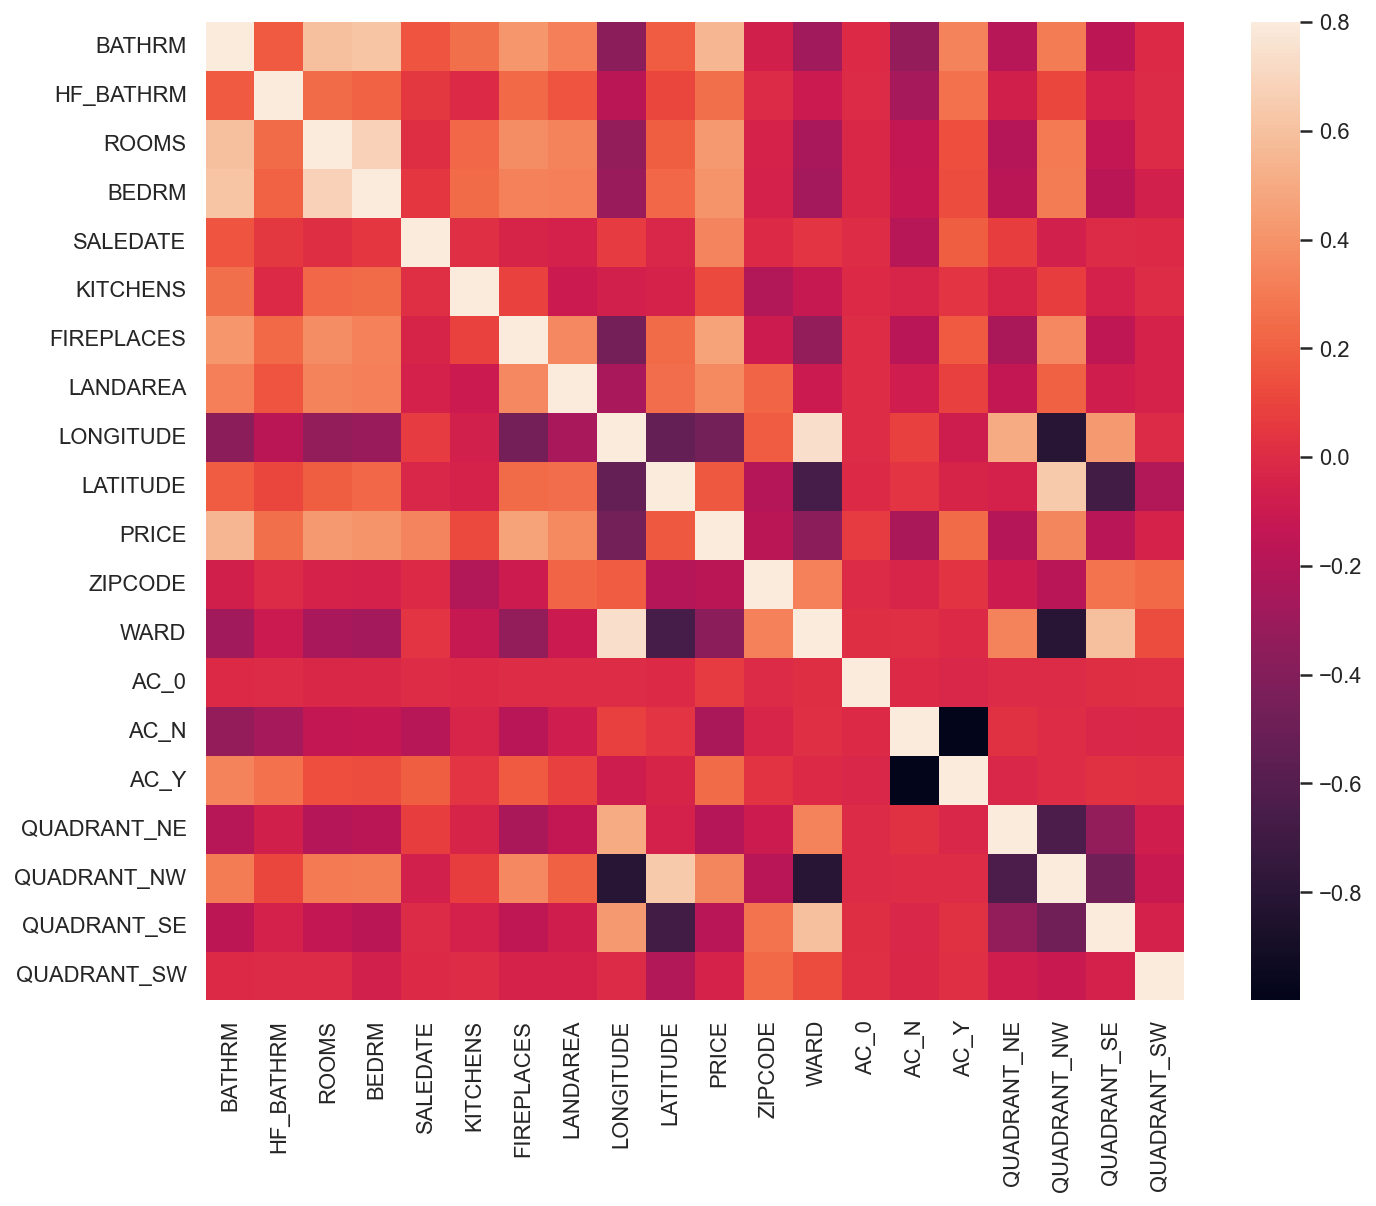

In [12]:
# Correlation Matrix
# Correlation Matrix Heatmap
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

A lot of data to look at. Lets improve the figure and reduce into the top 10 features most related to Sale Price.

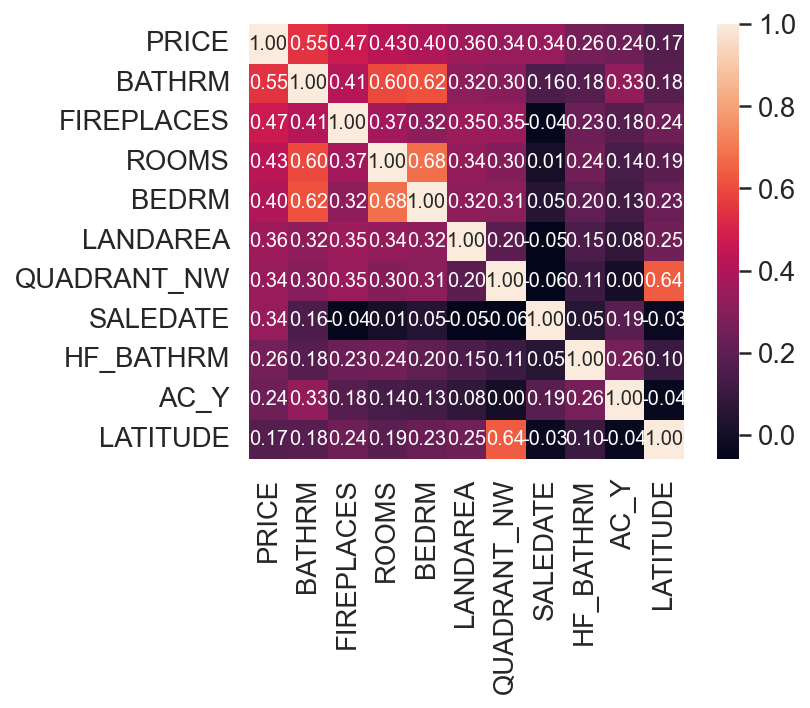

In [13]:
# Top 10 Heatmap
k = 11 #number of variables for heatmap(10 features and one target)
cols = corrmat.nlargest(k, 'PRICE')['PRICE'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [14]:
# update the dataframe based on the above features
cols = ["BATHRM","FIREPLACES","ROOMS", 
        "BEDRM","LANDAREA","QUADRANT_NW",
      "SALEDATE","HF_BATHRM","AC_Y","LATITUDE","LONGITUDE"]
df = df[cols+["PRICE"]]
df.head()

,BATHRM,FIREPLACES,ROOMS,BEDRM,LANDAREA,QUADRANT_NW,SALEDATE,HF_BATHRM,AC_Y,LATITUDE,LONGITUDE,PRICE
0,3,4,9,5,1680,1.0,2016.0,1,1.0,38.914684,-77.040678,2100000.0
1,3,3,8,5,1680,1.0,2006.0,1,1.0,38.914683,-77.040629,1602000.0
2,3,4,10,5,2196,1.0,2010.0,2,1.0,38.914331,-77.039715,1950000.0
3,3,1,8,4,1627,1.0,2011.0,1,1.0,38.915408,-77.040129,1050000.0
4,3,1,7,3,1424,1.0,2018.0,1,1.0,38.915017,-77.039903,1430000.0


In [15]:
# update features
X= df.drop(columns="PRICE")
X.shape

(55028, 11)

# Cleaning missing values

In [16]:
# First check the number of missing values of each features and target
for col in df.columns:
    print(f"Column {col} has {df[col].isnull().sum()} null values")

Column BATHRM has 0 null values
Column FIREPLACES has 0 null values
Column ROOMS has 0 null values
Column BEDRM has 0 null values
Column LANDAREA has 0 null values
Column QUADRANT_NW has 0 null values
Column SALEDATE has 0 null values
Column HF_BATHRM has 0 null values
Column AC_Y has 0 null values
Column LATITUDE has 0 null values
Column LONGITUDE has 0 null values
Column PRICE has 0 null values


No missing values. 

# B. Spliting data training and testing dataset

In [17]:
# Split the preprocessed data into our features and target array
X = df.drop(columns="PRICE")

In [18]:
# Split the preprocessed data into a training and testing dataset
y = df["PRICE"].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1)


In [19]:
X_train.shape

(41271, 11)

In [20]:
X_test.shape

(13757, 11)

In [21]:
y_train.shape

(41271, 1)

In [22]:
y_test.shape

(13757, 1)

# C. Scaling features and target  data using StandardScaler 

In [23]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)


(41271, 11)
(13757, 11)


In [24]:
# convert X train and test lists to data fraime

X_train_df= pd.DataFrame(X_train_scaled, columns=df.drop("PRICE", 
                        axis=1).columns)


X_test_df= pd.DataFrame(X_test_scaled, columns=df.drop("PRICE", 
                        axis=1).columns)
X_train_df.head()



,BATHRM,FIREPLACES,ROOMS,BEDRM,LANDAREA,QUADRANT_NW,SALEDATE,HF_BATHRM,AC_Y,LATITUDE,LONGITUDE
0,-0.121157,-0.760566,-0.625588,-0.339607,0.303698,-0.963707,-0.276653,0.549254,0.58844,-0.805900,2.103283
1,1.887394,-0.760566,2.566761,2.606358,-0.613233,1.037660,-0.705413,-1.115082,0.58844,-0.172058,-0.028027
2,-1.125433,0.444537,-0.625588,-0.339607,-0.536978,1.037660,1.152547,-1.115082,0.58844,-0.095762,-0.330781
3,0.883118,-0.760566,-0.093530,-0.339607,-0.494476,-0.963707,1.295467,0.549254,0.58844,-0.844569,0.263834
4,-1.125433,-0.760566,-0.625588,-0.339607,-0.536978,-0.963707,0.723787,0.549254,0.58844,0.092705,0.684136


In [25]:
# view the X test data frame
X_test_df.head()

,BATHRM,FIREPLACES,ROOMS,BEDRM,LANDAREA,QUADRANT_NW,SALEDATE,HF_BATHRM,AC_Y,LATITUDE,LONGITUDE
0,0.883118,0.444537,-0.093530,1.624370,-0.263837,1.037660,-0.419573,0.549254,0.588440,0.906770,-0.360676
1,-1.125433,-0.760566,-0.625588,-0.339607,-0.116015,1.037660,0.152107,0.549254,-1.699408,0.560076,-0.199574
2,-0.121157,-0.760566,-0.625588,-1.321595,-0.736991,1.037660,1.152547,-1.115082,0.588440,0.391151,-0.349666
3,-0.121157,-0.760566,-0.625588,-1.321595,-0.511977,-0.963707,1.009627,0.549254,0.588440,-0.644724,0.490223
4,-1.125433,0.444537,-0.093530,-0.339607,1.006867,1.037660,-2.134613,0.549254,-1.699408,1.432018,-0.055185


In [26]:
# Scale Y_train
# Fit the StandardScaler
y_scaler = scaler.fit(y_train)

# Scale the data
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# converst the array to Datafrane
y_train_df=pd.DataFrame(data=y_train_scaled,columns=["PRICE"])
y_test_df=pd.DataFrame(data=y_test_scaled,columns=["PRICE"])

y_train_df.head()

,PRICE
0,-0.296447
1,-0.623925
2,0.641734
3,1.128526
4,-0.533824


In [27]:
# view y-test
y_test_df.head()

,PRICE
0,-0.066327
1,-0.199088
2,0.181494
3,0.243450
4,-0.641627


Text(0.5, 1.0, 'pearson correlation')

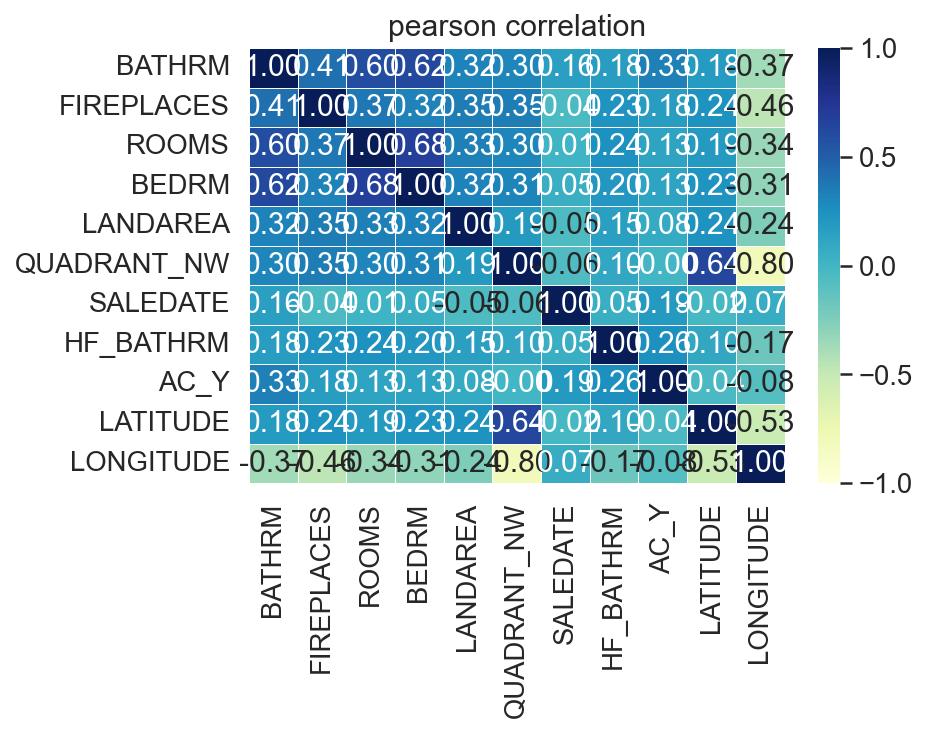

In [28]:
# Check for multicollinearity problem, which refers to a situation in which 
# two or more explanatory variables in a multiple regression model are highly linearly related.
corr_matrix = X_train_df.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")


We can see that there is no a such very high correlation(0.9 and above) among the features


# We can further reduce number of features using  the following methods
- use ensemble methods to get feature importance.
-Lowest pvalue_selected_features from linear regression

C:\Users\seidy\anaconda3\envs\mlenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


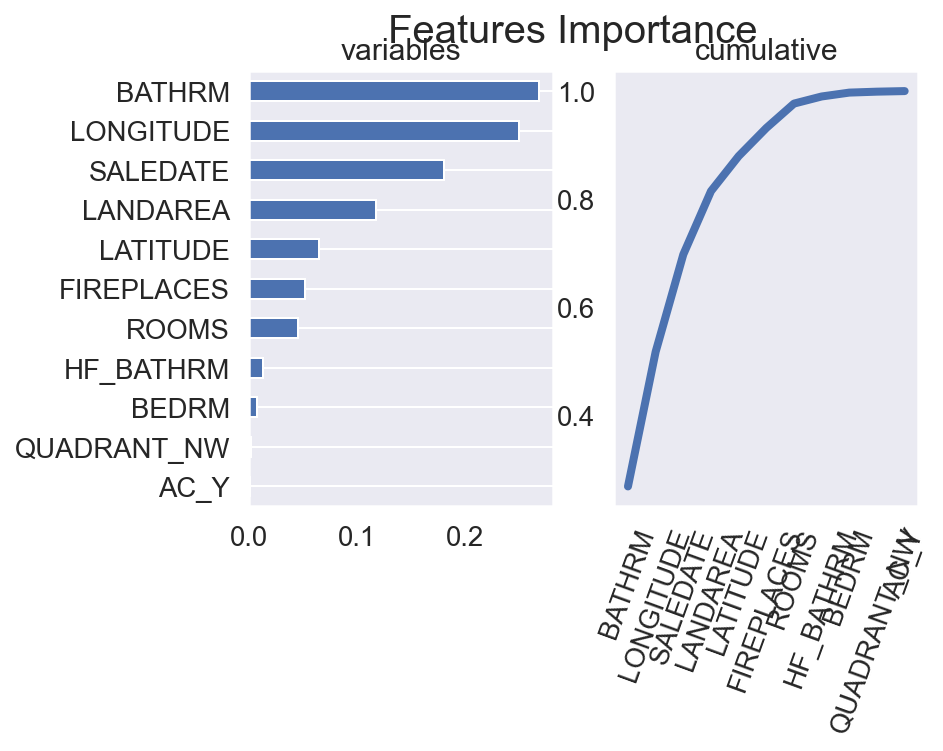

In [29]:
# ensemble methods :GradientBoostingRegressor()
feature_names = X_train_df.columns.tolist()
model = GradientBoostingRegressor()
## Importance
model.fit(X_train_df,y_train_df)
importances = model.feature_importances_
## Put in a pandas 
X_importances = pd.DataFrame({"IMPORTANCE":importances, 
                              "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
                                                                     ascending=False)
X_importances['cumsum'] =   X_importances['IMPORTANCE'].cumsum(axis=0)
X_importances =X_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
X_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
X_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(X_importances)), 
          xticklabels=X_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

 Bathrm, SALEDATE, LANDAREA, LONGITUDE,LATITUDEm,FIREPLACEs,ROOMS are most important features

In [30]:
# update the X data based on these feature
cols = ["BATHRM","SALEDATE","FIREPLACES", "ROOMS","LATITUDE","LONGITUDE"]
X_train_df = X_train_df [cols]
X_test_df = X_test_df [cols]
X_test_df.head()

,BATHRM,SALEDATE,FIREPLACES,ROOMS,LATITUDE,LONGITUDE
0,0.883118,-0.419573,0.444537,-0.093530,0.906770,-0.360676
1,-1.125433,0.152107,-0.760566,-0.625588,0.560076,-0.199574
2,-0.121157,1.152547,-0.760566,-0.625588,0.391151,-0.349666
3,-0.121157,1.009627,-0.760566,-0.625588,-0.644724,0.490223
4,-1.125433,-2.134613,0.444537,-0.093530,1.432018,-0.055185


# D. Modeling and Prediction

In [32]:
from sklearn.model_selection import KFold, cross_val_score
# k-fold cross-validation is used to compare results of different models by splitting
# the data k times into train and validation sets and for each split, 
# the model is trained and tested. It’s used to check how well 
# the model is able to get trained by some data and predict unseen data.

df=

# D1 Linear Regression

In [53]:
#Intitaite the linear model
Linear_model = linear_model.LinearRegression()
# Fitting the model
Linear_model = Linear_model.fit(X_train_df, y_train_df)

# Evaluate the model
y_pred = Linear_model.predict(X_test_df)
R2= r2_score(y_test_df, y_pred)
Mse = mean_squared_error(y_test_df, y_pred)
print(f"The R2 of Linear Regression Model is {round(R2,2)}")
print(f"The mean square error of Linear Regression Model is {round(Mse,2)}")

The R2 of Linear Regression Model is 0.59
The mean square error of Linear Regression Model is 0.32


# D2: Gradient Boosting


In [56]:
#Intitaite the Gradient Boost model
Gradient_model= GradientBoostingRegressor()

In [57]:
# Fitting the model
Gradient_model =Gradient_model.fit(X_train_df, y_train_df)

# Evaluate the model
y_pred = Gradient_model.predict(X_test_df)
R2= r2_score(y_test_df, y_pred)
Mse = mean_squared_error(y_test_df, y_pred)
print(f"The R2 of Gradient Boosting Model is {round(R2,2)}")
print(f"The mean square error of Gradient Boosting Model is {round(Mse,2)}")

C:\Users\seidy\anaconda3\envs\mlenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The R2 of Gradient Boosting Model is 0.69
The mean square error of Gradient Boosting Model is 0.25


# D3.Random Forest Regressor

In [67]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

C:\Users\seidy\AppData\Local\Temp\ipykernel_16400\4010462906.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_df, y_train_df)


RandomForestRegressor(n_jobs=-1)

In [68]:
# Predict and Evaluate the model
y_pred = rf.predict(X_test_df)
R2= r2_score(y_test_df, y_pred)
Mse = mean_squared_error(y_test_df, y_pred)
print(f"The R2 of RandomForest Regressor is {round(R2,2)}")
print(f"The mean square error of RandomForest Regressor is {round(Mse,2)}")

The R2 of RandomForest Regressor is 0.73
The mean square error of RandomForest Regressor is 0.22


# E. Make future prediction